# Regressão Linear

## Resumo

O presente trabalho consiste em aplicar regressão linear, utilizando decomposição QR, no dataset **Admission Predict**, na versão 1.1. O dataset consiste em um conjunto de notas de um alunos e universidades e na última coluna a chance de o aluno ser admitido em um curso. Foi calculado a Raiz Quadrada do Erro Quadrático Médio (RMSE) do conjunto de testes, e como resultado tivemos $0.060$.

### Regressão linear

A regressão linear é uma técnica estatística utilizada para entender a relação entre uma variável dependente (a variável que estamos tentando prever, nesse caso a chance de admissão de um candidato) e uma ou mais variáveis independentes (os recursos ou preditores, que nesse caso são as notas, etc). O objetivo principal da regressão linear é modelar essa relação de forma a prever a variável dependente com base nos valores dos recursos.

A regressão linear assume que a relação entre as variáveis é linear, ou seja, pode ser representada por uma linha reta. Dificilmente (para não dizer que é impossível) um sistema real poderá ser definido por uma reta e, justamente por isso, o modelo de regressão linear busca encontrar a melhor linha reta que se ajusta aos dados, minimizando a diferença entre os valores previstos e os valores reais (erro).

### Decomposição QR

A decomposição QR foi escolhida para ser usada na regressão linear devido a sua estabilidade numérica e eficiência computacional. Sem ela, seria necessário calcular inversas de matrizes visando encontrar a solução de mínimos quadrados (mais aproximada) do sistema $Ax=b$, porém calcular inversas é computacionalmente ruim.

O objetivo aqui é decompor a matriz $A$ em duas matrizes $Q$ e $R$, onde $Q$ é uma matriz ortogonal, onde todas as colunas são ortonormais, e $R$ é uma matriz triangular superior. Isso simplifica a resolução do sistema de equações lineares. A função `scipy.linalg.qr()` é usada para calcular essa decomposição. Em seguida, a equação normal é resolvida utilizando `scipy.linalg.solve_triangular()` para encontrar os coeficientes do modelo.

## Resolução

### Importando bibliotecas e definindo funções

Importando as bibliotecas principais que serão utilizadas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import qr
from scipy.linalg import solve_triangular
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
import time

WORKSPACE = os.path.curdir
DATASET_PATH = os.path.join(WORKSPACE, "dataset", "Admission_Predict_Ver1.1.csv")

def calculate_rmse(real, pred):
    return np.sqrt(mean_squared_error(real, pred))

def add_bias_column(matrix):
    return np.hstack((matrix, np.ones((matrix.shape[0], 1))))

def plot_real_vs_pred_graph(real, pred):
    plt.scatter(real, pred)
    plt.plot([real.min(), real.max()], [real.min(), real.max()], '--k')
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Estimados')
    plt.title('Valores Reais vs. Valores Estimados')
    plt.show()


### Carregando dataset e uma breve análise

Carregando o dataset.

In [2]:
dataset = pd.read_csv(DATASET_PATH, sep=",")
dataset

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
495,496,332,108,5,4.5,4.0,9.02,1,0.87
496,497,337,117,5,5.0,5.0,9.87,1,0.96
497,498,330,120,5,4.5,5.0,9.56,1,0.93
498,499,312,103,4,4.0,5.0,8.43,0,0.73


Como a primeira coluna do dataset é apenas um número serial, não possui impacto nenhum na regressão, então vamos remover essa coluna do dataset, ficando apenas com as outras 8 colunas restantes (contando as variaveis independentes e a variável dependente).

In [3]:
dataset = dataset.drop("Serial No.", axis=1)
dataset

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...
495,332,108,5,4.5,4.0,9.02,1,0.87
496,337,117,5,5.0,5.0,9.87,1,0.96
497,330,120,5,4.5,5.0,9.56,1,0.93
498,312,103,4,4.0,5.0,8.43,0,0.73


Apenas um descritivo do dataset.

In [4]:
dataset.describe().round(2)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00
mean,316.47,107.19,3.11,3.37,3.48,8.58,0.56,0.72
std,11.30,6.08,1.14,0.99,0.93,0.60,0.50,0.14
min,290.00,92.00,1.00,1.00,1.00,6.80,0.00,0.34
25%,308.00,103.00,2.00,2.50,3.00,8.13,0.00,0.63
50%,317.00,107.00,3.00,3.50,3.50,8.56,1.00,0.72
75%,325.00,112.00,4.00,4.00,4.00,9.04,1.00,0.82
max,340.00,120.00,5.00,5.00,5.00,9.92,1.00,0.97


#### Uma das vantagens da decomposição QR.

Apenas para reforçar a escolha da decomposição QR, computando a correlação dois a dois das variáveis, pode-se perceber que a chance de admissão está fortemente ligada as variáveis independentes `GRE Score`, `CGPA` e `TOEFL Score`. Se fossemos resolver de forma "tradicional", esse tipo de observação seria importante, dado que é melhor que escolhamos variáveis com maior influência no resultado, desde que não existam recursos altamente correlacionados.

No caso do dataset usado, as variáveis mencionadas possuem de fato uma alta correlação, o que dificultaria um resultado preciso, porém, a decomposição QR é capaz de lidar efetivamente com matrizes singulares ou mal condicionadas.

In [5]:
dataset.corr().round(2)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
GRE Score,1.00,0.83,0.64,0.61,0.52,0.83,0.56,0.81
TOEFL Score,0.83,1.00,0.65,0.64,0.54,0.81,0.47,0.79
University Rating,0.64,0.65,1.00,0.73,0.61,0.71,0.43,0.69
SOP,0.61,0.64,0.73,1.00,0.66,0.71,0.41,0.68
LOR,0.52,0.54,0.61,0.66,1.00,0.64,0.37,0.65
CGPA,0.83,0.81,0.71,0.71,0.64,1.00,0.50,0.88
Research,0.56,0.47,0.43,0.41,0.37,0.50,1.00,0.55
Chance of Admit,0.81,0.79,0.69,0.68,0.65,0.88,0.55,1.00


### Construção da Matriz $A$ e o Vetor $b$

Agora vamos determinar quem é a variável dependente e quem são as variáveis independentes, no caso, "Chance of Admit" e todas as outras, respectivamente.

In [6]:
y = dataset["Chance of Admit"]
X = dataset[dataset.columns[:-1]]

Após determinar os recursos e a variável dependente, precisamos separar os dados em conjuntos de treinamento e teste, sendo $70\%$ e $30\%$ respectivamente para cada grupo. Usamos a função train_test_split da biblioteca SciKit Learn.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)
print("y_train.shape", y_train.shape)
print("y_test.shape", y_test.shape)

X_train.shape (350, 7)
X_test.shape (150, 7)
y_train.shape (350,)
y_test.shape (150,)


O objetivo dos proximos dois passos é preparar os dados de treinamento para a análise de regressão. A matriz A é construída com os recursos do conjunto de treinamento, sendo adicionada uma coluna de 1s com funções do numpy para incluir o termo de viés. Este termo permite que o modelo aprenda um intercepto além das relações lineares entre os recursos e a variável dependente. Já o vetor b é construído com os valores da variável dependente correspondentes aos exemplos de treinamento.

In [8]:
X_train_bias = add_bias_column(X_train)
X_train_bias

array([[330.  , 115.  ,   5.  , ...,   9.34,   1.  ,   1.  ],
       [299.  , 102.  ,   3.  , ...,   8.62,   0.  ,   1.  ],
       [322.  , 110.  ,   5.  , ...,   9.1 ,   1.  ,   1.  ],
       ...,
       [302.  ,  99.  ,   1.  , ...,   7.25,   0.  ,   1.  ],
       [309.  , 105.  ,   2.  , ...,   7.68,   0.  ,   1.  ],
       [314.  , 106.  ,   2.  , ...,   8.25,   0.  ,   1.  ]])

In [9]:
A = X_train_bias
b = y_train
print("A:", A)
print("-----------------")
print("b:", b)

A: [[330.   115.     5.   ...   9.34   1.     1.  ]
 [299.   102.     3.   ...   8.62   0.     1.  ]
 [322.   110.     5.   ...   9.1    1.     1.  ]
 ...
 [302.    99.     1.   ...   7.25   0.     1.  ]
 [309.   105.     2.   ...   7.68   0.     1.  ]
 [314.   106.     2.   ...   8.25   0.     1.  ]]
-----------------
b: 5      0.90
116    0.56
45     0.88
16     0.66
462    0.62
       ... 
106    0.87
270    0.72
348    0.57
435    0.55
102    0.62
Name: Chance of Admit, Length: 350, dtype: float64


Aqui ocorre a decomposição de $A$ em duas matrizes $Q$ e $R$, onde $Q$ é ortogonal e $R$ é triangular superior. A função `qr()` é usada para calcular essa decomposição. Em seguida, a equação normal é resolvida utilizando a função `solve_triangular()` para encontrar os coeficientes do modelo.

In [10]:
Q, R = qr(A, mode='economic')

In [11]:
coefficients = solve_triangular(R, np.dot(Q.T, b))

A partir daqui temos o nosso modelo treinado, com os coeficientes necessários para fazer a predição da chance de admissão baseado nos recursos que forem fornecidos. 

## Testes

### Calculando resultado

Para testar o modelo que foi treinado, vamos repetir o mesmo passo de preparação que fizemos com os dados de treino, porém agora com os de teste.

In [12]:
X_test_bias = add_bias_column(X_test)
X_test_bias

array([[334.  , 116.  ,   4.  , ...,   9.54,   1.  ,   1.  ],
       [314.  , 108.  ,   4.  , ...,   9.04,   1.  ,   1.  ],
       [315.  , 105.  ,   2.  , ...,   7.65,   0.  ,   1.  ],
       ...,
       [324.  , 113.  ,   4.  , ...,   8.79,   0.  ,   1.  ],
       [312.  , 104.  ,   3.  , ...,   8.09,   0.  ,   1.  ],
       [312.  , 106.  ,   3.  , ...,   8.57,   0.  ,   1.  ]])

Agora para calcular as predições, basta calcular o produto escalar (interno) entre os recursos, nesse caso a matriz de teste com viés, e os coeficientes obtidos.

In [13]:
y_pred = np.dot(X_test_bias, coefficients)
y_pred

array([0.91741506, 0.79586339, 0.57331415, 0.71296937, 0.81766541,
       0.86159946, 0.47853569, 0.65501836, 0.82444308, 0.80745246,
       0.72441143, 0.73075277, 0.65336494, 0.93602084, 0.82603249,
       0.51251694, 0.83678742, 0.59441502, 0.53763563, 0.56844851,
       0.66183719, 0.55405325, 0.71919744, 0.79241287, 0.78092962,
       0.60437535, 0.95120337, 0.84627844, 0.62940907, 0.74281956,
       0.55814697, 0.73597733, 0.54933106, 0.86192594, 0.65322038,
       0.73614535, 0.55561053, 0.9588285 , 0.64202803, 0.70997521,
       0.96801486, 0.57117293, 0.66729947, 0.85771049, 0.94159306,
       0.58142542, 0.95967505, 0.83736121, 0.7912764 , 0.92684222,
       0.88830229, 0.56385625, 0.70660472, 0.5220698 , 0.95425583,
       0.59561912, 0.95867003, 0.74402994, 0.66664456, 0.49857978,
       0.63114266, 0.67738991, 0.6020934 , 0.59462762, 0.44030549,
       0.58979469, 0.8672294 , 0.89754515, 0.66041412, 0.70992114,
       0.6143678 , 0.78484261, 0.69143165, 0.56383959, 0.55636

### Verificando erro

Após feita a estimação da variável dependente, o RMSE é calculado comparando os valores previstos com os valores reais no conjunto de teste. Isso fornece uma medida da precisão do modelo.

In [14]:
rmse = calculate_rmse(y_test, y_pred)
print("RMSE:", rmse)

RMSE: 0.060284473965118976


## Visualizando os resultados

Para entender melhor a performance do modelo, é útil visualizar a relação entre os valores reais e os valores previstos. O gráfico de dispersão abaixo foi criado com os valores reais no eixo x e os valores previstos no eixo y. A reta pontilhada indica onde os pontos deveriam estar se os valores previstos fossem perfeitamente iguais aos valores reais.

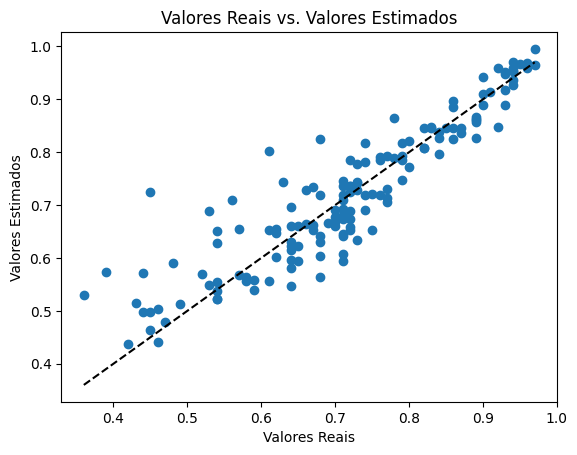

In [15]:
plot_real_vs_pred_graph(y_test, y_pred)

Como solicitado, também vamos visualizar os resultados para predições feitas em cima do conjunto de treinamento

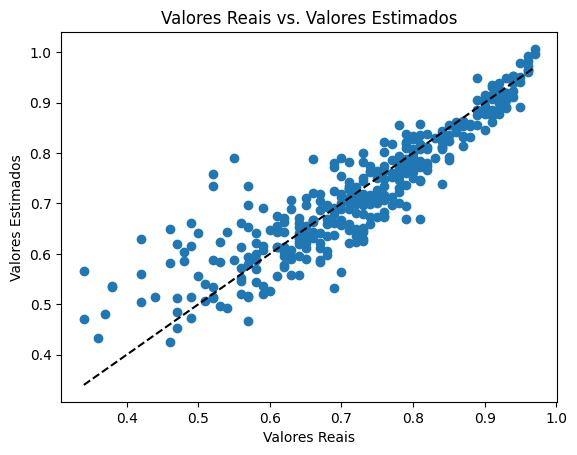

In [16]:
y_pred_train = np.dot(X_train_bias, coefficients)

plot_real_vs_pred_graph(y_train, y_pred_train)

In [17]:
print("RMSE treinamento:", calculate_rmse(y_train, y_pred_train))

RMSE treinamento: 0.05946908400510449
